# Processes

## Introduction

In simulation and modelling we encounter a wide range of stochastic processes. But most fall into a few common categories: Ito processes, martingales, Markov processes, Gaussian processes, etc. We attempt to take this into account in our treatment of stochastic processes in thalesians.tsa, where we represent different categories of stochastic processes with distinct abstract data types.

In [4]:
%matplotlib inline
import os, sys
sys.path.append(os.path.abspath('../../main/python'))
import matplotlib.pyplot as plt
import thalesians.tsa.processes as proc
import thalesians.tsa.simulation as sim

## Ito processes

An **Ito process** is defined to be an adapted stochastic process that can be expressed as the sum of an integral with respect to a Wiener process and an integral with respect to time,
$$X_t = X_0 + \int_0^t \mu_s \, ds + \int_0^t \sigma_s \, dW_s,$$
or, in differential form,
$$dX_s = \mu_s \, ds + \sigma_s \, dW_s,$$
where $W$ is a Wiener process, $\sigma$ a predictable $W$-integrable process, $\mu$ predictable and Lebesgue-integrable. The integrability conditions can be expressed as
$$\int_0^t (\sigma_s^2 + |\mu_s|) \, ds < \infty.$$

$\mu$ and $\sigma$ are allowed to depend both on the time and current state, so we can write
$$X_t = X_0 + \int_0^t \mu(s, X_s) \, ds + \int_0^t \sigma(s, X_s) \, dW_s.$$

The function $\mu$ is referred to as **drift**, the function $\sigma$ as **diffusion**. The `ItoProcess` can thus be specified by providing these two functions:

In [2]:
X = proc.ItoProcess(drift=lambda t, x: -x, diffusion=lambda t, x: .25)

It can then be approximated with a stochastic time discrete approximation, such as the **Euler-Maruyama** strong Taylor approximation scheme:

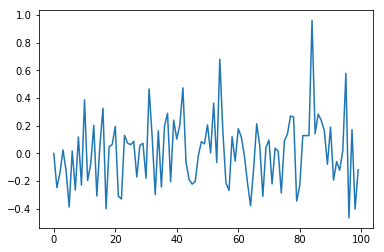

In [11]:
ts = []; xs = []
for t, x in sim.EulerMaruyama(process=X, times=sim.xtimes(0., 100.)):
    ts.append(t); xs.append(x.flatten())
plt.plot(ts, xs);

Since in this particular case the diffusion coefficient is constant, we could have defined X as

In [12]:
X = proc.ItoProcess(drift=lambda t, x: -x, diffusion=.25)

## Solved Ito processes
In case the stochastic differential equation
$$X_t = X_0 + \int_0^t \mu(s, X_s) \, ds + \int_0^t \sigma(s, X_s) \, dW_s$$
has a solution, it may be possible to compute the above integrals analytically. Although the rigorous theory of SDE requires one to specify what exactly one means by a "solution", we shall reserve the term **solved Ito process** for those Ito processes where these integrals can be computed analytically. Such processes should inherit from the `SolvedItoProcess` class and override its abstract method

In [14]:
def propagate(self, time, variate, time0, value0, state0=None):
    raise NotImplementedError()

Given the time `time0` and the process's value at that time, `value0`, and (if the process is stateful) the process's state, `state0`, at `time0`, as well as the random variate `variate` corresponding to the actual increment in the driving Brownian motion $W$, the `propagate` method will return the value of the process at `time`, `time >= time0`. If `propagate` is implemented, there is no need to re

## Markov processes
Informally, a Markov process models the motion of a particle that moves around in a measurable space $(E, \mathcal{E})$ in a memoryless way.

## Gaussian processes
